# LGBM and Percent Change

Modeling to predict the percent change between the two pools of data.

# When Using a Google Shared Drive

To mount a drive that is not yours but shared with you, you must:<br>
- go into Google Drive<br>
- select the DATASCI210 folder you want to use in Colab<br>
- Right click on the DATASCI210 folder<br>
- Select "Organize"<br>
- then "Add Shortcut"<br>
- then specify the shortcut to go into the "MyDrive" folder.<br>
- Then this code will 'work' out of the box. What could go wrong? <br>

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
GOOGLE_COLAB = False

if GOOGLE_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/DATASCI210/arbitrage_3M
  print(os.listdir("."))


In [3]:
def extract_df(location):
  """
  Funtion to extract transaction level files from Folder, iterates through all files looking for combination pool_id_XXXXXX

  Location Updated to work in Google Drive.

  """
  final_df = pd.DataFrame()

  for i in [x for x in os.listdir(location) if x.find(f'arbitrage_20240313_20240613_WETH_USDC')!=-1]:
    print(f"Reading: {i}")
    temp_df = pd.read_csv(f"{location}/{i}")
    try:
      temp_df['time']
      pass
    except:
      temp_df['DATE'] = temp_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).replace(hour=0, minute=0, second=0, microsecond=0))
    final_df = pd.concat([final_df,temp_df])
    #print('.',end='')

  try:
    final_df['DATE'] = final_df['time'].apply(lambda x: datetime.datetime(int(x[:4]),int(x[5:7]),int(x[8:10])))
  except:
    pass
  try:
    return final_df.drop('Unnamed: 0',axis=1).reset_index(drop=True)
  except:
    return final_df.reset_index(drop=True)

In [4]:
TRAINING_DATA_PATH = "../../arbitrage_3M/"
arbitrage_df = extract_df(TRAINING_DATA_PATH)


Reading: arbitrage_20240313_20240613_WETH_USDC_9.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_8.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_15.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_14.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_16.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_17.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_13.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_12.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_10.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_11.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_20.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_19.csv


/var/folders/7k/rctwsj8n1z92y6cwvtwzc2y80000gn/T/ipykernel_57943/3355236209.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df,temp_df])


Reading: arbitrage_20240313_20240613_WETH_USDC_18.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_5.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_4.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_6.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_7.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_3.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_2.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_0.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_1.csv


### Preprocessing Data

convert time to datetime.

In [5]:
arbitrage_sorted_df = arbitrage_df.sort_values(by='time', ascending=True)
arbitrage_sorted_df['time'] = pd.to_datetime(arbitrage_sorted_df['time'], format='ISO8601')
arbitrage_sorted_df = arbitrage_sorted_df.reset_index(drop=True)

# Find the first row with NaNs...
new_first_row = arbitrage_sorted_df['p0.eth_price_usd'].first_valid_index()
arbitrage_sorted_df = arbitrage_sorted_df.iloc[new_first_row:]
# remove NaNs from forward fill
has_nans = arbitrage_sorted_df.isna().any().any()
print("Are there any NaNs in the DataFrame?", has_nans)

Are there any NaNs in the DataFrame? False


In [6]:
# Here are some transaction rates from another notebook: 
# Pool 0 (0.3% fee): 8818.74hr of transactions or 11.7798 tph.
# Pool 1 (0.05% fee): 8819.09hr of transactions or 219.4892 tph.
rate0 = 11.7798
rate1 = 219.4892

# What is the mean time between transactions in the dataset: 
ds_seconds = arbitrage_sorted_df['time'].diff().iloc[1:].dt.total_seconds()
print(f"Mean Time (in seconds) between transactions: {np.array(ds_seconds).mean():.2f}")
print(f"Transactions per minute: {rate1 / 60:.2f}")

Mean Time (in seconds) between transactions: 11.78
Transactions per minute: 3.66


In [7]:
print(f"Transactions in Pool 0 (0.3%  fee) over three months: {arbitrage_sorted_df['p0.transaction_time'].unique().shape[0]}")
print(f"Transactions in Pool 1 (0.05% fee) over three months: {arbitrage_sorted_df['p1.transaction_time'].unique().shape[0]}")

Transactions in Pool 0 (0.3%  fee) over three months: 33081
Transactions in Pool 1 (0.05% fee) over three months: 380653


In [8]:
def find_closest_timestamp(df, time_col, minutes):
    # Ensure 'time' column is in datetime format
    df.loc[:, time_col] = pd.to_datetime(df[time_col])

    # Create a shifted version of the DataFrame with the target times
    shifted_df = df.copy()
    shifted_df[time_col] = shifted_df[time_col] - pd.Timedelta(minutes=minutes)

    # Merge the original DataFrame with the shifted DataFrame on the closest timestamps
    result_df = pd.merge_asof(df.sort_values(by=time_col),
                              shifted_df.sort_values(by=time_col),
                              on=time_col,
                              direction='backward',
                              suffixes=('', '_label'))

    # Select the required columns and rename them
    result_df = result_df[['time','percent_change','percent_change_label']]

    return result_df

# LGBM Training 
1 Minute Intervals - not fixed, 2 Lags, 8 tap rolling mean

### Training

In [28]:
FORECAST_WINDOW_MIN=1
MODEL_NAME="LGBM"

# model parameters (things that can be ablated using the same data)
NUM_LAGS = 2  # Number of lags to create
N_WINDOW_AVERAGE = 8 # rollling mean value

In [29]:

metrics = []

int_df = arbitrage_sorted_df[['time','percent_change']]
int_df = find_closest_timestamp(int_df, 'time', FORECAST_WINDOW_MIN)

for i in range(1, NUM_LAGS + 1):
    int_df[f'lag_{i}'] = int_df['percent_change'].shift(i)

int_df[f'rolling_mean_{N_WINDOW_AVERAGE}'] = int_df['percent_change'].rolling(window=N_WINDOW_AVERAGE).mean()

# prune excess rows from lagging operation
max_prune = max(N_WINDOW_AVERAGE,NUM_LAGS)
int_df = int_df.iloc[max_prune-1:]

has_nans = int_df.isna().any().any()
print("Are there any NaNs in the DataFrame?", has_nans)
if has_nans: 
    print(f"Found: {int_df.isna().sum()}")

# Create time index foer the dataframe.
int_df.index = int_df.pop('time')
int_df.index = pd.to_datetime(int_df.index)

# Create labels and training...
y = int_df.pop('percent_change_label')
X = int_df.copy()



Are there any NaNs in the DataFrame? False


In [30]:
# Columns used for inference:
X.columns

Index(['percent_change', 'lag_1', 'lag_2', 'rolling_mean_16'], dtype='object')

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10
}

evals_result = {}

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10, verbose=True),
        lgb.record_evaluation(evals_result)
        ]
)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
metrics.append({
    'MSE':mse,
    'RMSE':np.sqrt(mse),
    'R Squared':r2
})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 541280, number of used features: 4
[LightGBM] [Info] Start training from score -0.000203
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	train's l2: 8.20386e-07	valid's l2: 3.12892e-07


### Results

In [35]:
print("RMSE:", np.sqrt(mse))
print("R Squared:", r2)

RMSE: 0.000559367611217998
R Squared: 0.8819282820255814


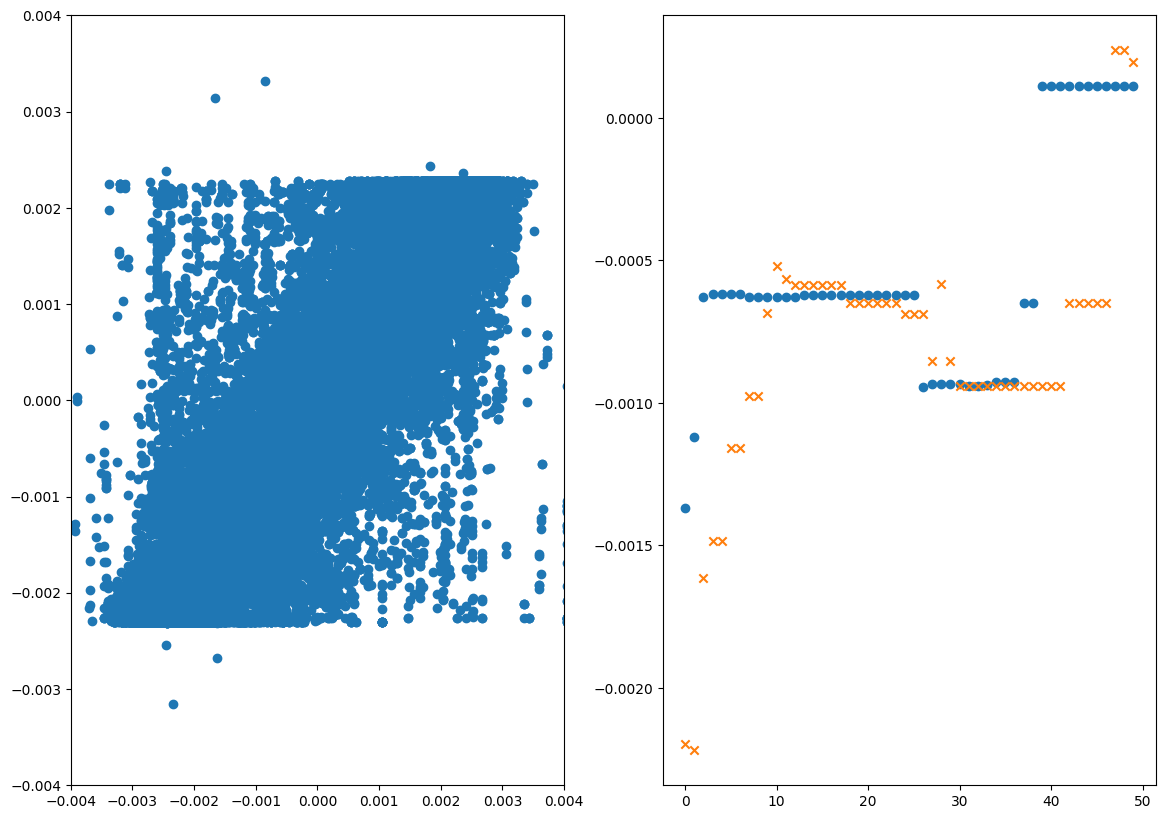

In [41]:
import matplotlib.pyplot as plt
figa, axsa = plt.subplots(1, 2, figsize=(14, 10))

axsa[0].scatter(y_test, y_pred)
axsa[0].set_xlim(-0.004,0.004)
axsa[0].set_ylim(-0.004,0.004)
axsa[1].scatter(range(len(y_pred[-50:])), y_test[-50:])
axsa[1].scatter(range(len(y_pred[-50:])), y_pred[-50:],marker='x')


## Save Results

In [225]:
#gbm.save_model(f'percent_change_{FORECAST_WINDOW_MIN}min_forecast_{MODEL_NAME}.pkl')
# Save the model with pickle
with open(f'percent_change_{FORECAST_WINDOW_MIN}min_forecast_{MODEL_NAME}.pkl', 'wb') as f:
    pickle.dump(gbm, f)

## Load Results

In [226]:
import pickle
def load_model(model_name):
    models_dir = os.path.join(os.getcwd(), '.')
    base_model_path = os.path.join(models_dir, model_name)
    
    # Check for different possible file extensions
    possible_extensions = ['', '.h5', '.pkl', '.joblib']
    model_path = next((base_model_path + ext for ext in possible_extensions if os.path.exists(base_model_path + ext)), None)
    if model_path is None:
        print(f"Model file not found for: {model_name}")
        return None
    print(model_path)
    try:
        #if model_name.startswith("LSTM"):
        #    model = tf.keras.models.load_model(model_path)
        #else:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"Model {model_name} loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

In [227]:
print(f"{FORECAST_WINDOW_MIN} minute forecast")

1 minute forecast


In [228]:
y_test.iloc[0]

-0.000945365210858

In [229]:
X_test.iloc[0]

percent_change        -0.000946
percent_change_ewm    -0.000536
percent_change_lag1   -0.001001
percent_change_lag2   -0.001189
Name: 2024-05-25 20:07:00, dtype: float64

In [230]:
#loaded_model = lgb.Booster(model_file=f'percent_change_{FORECAST_WINDOW_MIN}min_forecast_{MODEL_NAME}.pkl')
loaded_model = load_model(f'percent_change_{FORECAST_WINDOW_MIN}min_forecast_{MODEL_NAME}')
if loaded_model is None: 
    print('No model found.')
else:
    # make sure that pulling a single sample still results
    # in a properly formated data frame. 1 bracket gives
    # you a DataSeries, 2 gives you a Dataframe.
    print(loaded_model.predict(X_test.iloc[[0]])[0])

/Users/das/DATASCI210/arbitrage_playground/notebooks/./percent_change_1min_forecast_LGBM.pkl
Model percent_change_1min_forecast_LGBM loaded successfully from /Users/das/DATASCI210/arbitrage_playground/notebooks/./percent_change_1min_forecast_LGBM.pkl
-0.0009436166232362283
